In [1]:
from pymongo import MongoClient
from statistics import mean, stdev
from pandas import DataFrame
from collections import Counter
import matplotlib as mpl

# Experiment 1

How many files are finished after a certain time?

In [2]:
def get_run_times_per_parser_for_all_success():
    with MongoClient() as mongo:
        db = mongo['master']
        return db['metrics'].aggregate([
            {
                '$group': {
                    '_id': '$fileId',
                    'successCount': {
                        '$sum': {
                            '$cond': [
                                {'$eq': ['$status', 'success']},
                                1,
                                0
                            ]
                        }    
                    },
                    'metrics': {
                        '$push': {
                            'parser': '$parser',
                            'runTime': '$runTime'
                        }
                    }
                }
            },{
                '$match': {'successCount': 5}    
            },{
                '$unwind': '$metrics'
            },{
                '$group': {
                    '_id': '$metrics.parser',
                    'runTimes': {
                        '$push': '$metrics.runTime'
                    }
                }
            }
        ])

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


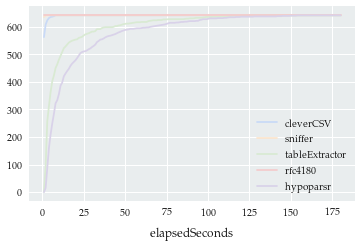

In [3]:
run_times_per_parser = [*get_run_times_per_parser_for_all_success()]
DataFrame([
    {
        'elapsedSeconds': elapsed_seconds,
        **{
            run_times['_id']: sum(run_time <= elapsed_seconds for run_time in run_times['runTimes'])
            for run_times in run_times_per_parser
        }
    }
    for elapsed_seconds in range(1, 181)
]).plot(y=['cleverCSV', 'sniffer', 'tableExtractor', 'rfc4180', 'hypoparsr'], x='elapsedSeconds')

# Experiment 2 - not meaningful

What is the average run time/ std. dev. when partitioning the files by file type?

In [4]:
def get_run_time_per_parser_by_file_type(file_type):
    with MongoClient() as mongo:
        db = mongo['master']
        return db['metrics'].aggregate([
            {
                '$match': {
                    **({'fileMetrics_fileType': file_type} if file_type else {})
                }
            },
            {
                '$group': {
                    '_id': '$parser',
                    'runTimes': {
                        '$push': '$runTime'
                    }
                }
            }
        ])

In [5]:
DataFrame([
    {
        'parser': run_times['_id'],
        'avgRunTime': mean(run_time for run_time in run_times['runTimes'] if not (run_time is None)),
        'stdDeviation': stdev(run_time for run_time in run_times['runTimes'] if not (run_time is None))
    }
    for run_times in get_run_time_per_parser_by_file_type('simple')
])

,parser,avgRunTime,stdDeviation
0,hypoparsr,18.092964,25.510724
1,cleverCSV,4.285401,16.087847
2,sniffer,1.396203,9.234676
3,rfc4180,0.002159,0.001688
4,tableExtractor,15.659268,27.140162


In [6]:
DataFrame([
    {
        'parser': run_times['_id'],
        'avgRunTime': mean(run_time for run_time in run_times['runTimes'] if not (run_time is None)),
        'stdDeviation': stdev(run_time for run_time in run_times['runTimes'] if not (run_time is None))
    }
    for run_times in get_run_time_per_parser_by_file_type('complex_single')
])

,parser,avgRunTime,stdDeviation
0,hypoparsr,16.154595,21.679789
1,cleverCSV,3.959834,12.450120
2,sniffer,2.018345,13.568058
3,rfc4180,0.002127,0.001698
4,tableExtractor,14.123829,25.316937


In [7]:
DataFrame([
    {
        'parser': run_times['_id'],
        'avgRunTime': mean(run_time for run_time in run_times['runTimes'] if not (run_time is None)),
        'stdDeviation': stdev(run_time for run_time in run_times['runTimes'] if not (run_time is None))
    }
    for run_times in get_run_time_per_parser_by_file_type('complex_multi')
])

,parser,avgRunTime,stdDeviation
0,rfc4180,0.002486,0.001633
1,sniffer,0.967865,3.392138
2,cleverCSV,4.240471,18.599283
3,hypoparsr,16.098713,23.091916
4,tableExtractor,12.914668,19.503208


# Experiment 3

Is the run time depending on file size?

In [8]:
def get_run_times_per_parser_per_file():
    with MongoClient() as mongo:
        db = mongo['master']
        return db['metrics'].aggregate([
            {
                '$addFields': {
                    'lineCountBin': {
                        '$toInt': {
                            '$divide': [
                                '$lineMetrics_lineCount', 1000
                            ]
                        }
                    }
                }
            }, {
                '$group': {
                    '_id': {
                        'fileId': '$fileId', 
                        'bin': '$lineCountBin'
#                         'bin': '$lineMetrics_lineCount'
                    }, 
                    'successCount': {
                        '$sum': {
                            '$cond': [
                                {
                                    '$eq': [
                                        '$status', 'success'
                                    ]
                                }, 1, 0
                            ]
                        }
                    }, 
                    'metrics': {
                        '$push': {
                            'parser': '$parser', 
                            'runTime': '$runTime'
                        }
                    }
                }
            }, {
                '$match': {
                    'successCount': 5
                }
            }
        ])

Text(0, 0.5, 'line count 1,000')

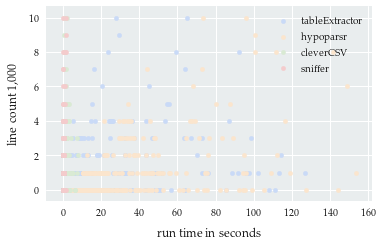

In [9]:
df = DataFrame([
    {
        'bin': metrics['_id']['bin'],
        **{
            parser_metric['parser']: parser_metric['runTime']
            for parser_metric in metrics['metrics']
        }
    }
    for metrics in get_run_times_per_parser_per_file()
])
ax1 = df.plot(kind='scatter', x='tableExtractor', label='tableExtractor', y='bin', color=mpl.rcParams['axes.prop_cycle'].by_key()['color'][0])
ax2 = df.plot(kind='scatter', x='hypoparsr', label='hypoparsr', y='bin', ax=ax1, color=mpl.rcParams['axes.prop_cycle'].by_key()['color'][1])
ax3 = df.plot(kind='scatter', x='cleverCSV', label='cleverCSV', y='bin', ax=ax2, color=mpl.rcParams['axes.prop_cycle'].by_key()['color'][2])
ax4 = df.plot(kind='scatter', x='sniffer', label='sniffer', y='bin', ax=ax3, color=mpl.rcParams['axes.prop_cycle'].by_key()['color'][3])
ax4.set_xlabel('run time in seconds')
ax4.set_ylabel('line count 1,000')

# Experiment 4

What is the average run time/ std. dev for processing a single line?

In [10]:
def get_runtimes_per_line_per_parser():
    with MongoClient() as mongo:
        db = mongo['master']
        return db['metrics'].aggregate([
            {
                '$group': {
                    '_id': '$fileId', 
                    'successCount': {
                        '$sum': {
                            '$cond': [
                                {
                                    '$eq': [
                                        '$status', 'success'
                                    ]
                                }, 1, 0
                            ]
                        }
                    }, 
                    'metrics': {
                        '$push': {
                            'parser': '$parser', 
                            'runTime': {
                                '$divide': [
                                    '$runTime', '$lineMetrics_lineCount'
                                ]
                            }
                        }
                    }
                }
            }, {
                '$match': {
                    'successCount': 5
                }
            }, {
                '$unwind': {
                    'path': '$metrics'
                }
            }
        ])

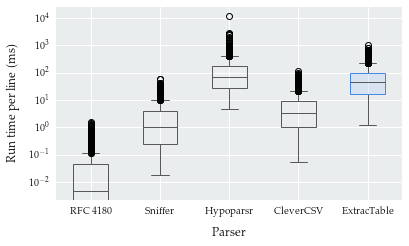

In [24]:
parser_map = {'cleverCSV': 'CleverCSV', 'hypoparsr': 'Hypoparsr', 'rfc4180': 'RFC 4180', 'sniffer': 'Sniffer', 'tableExtractor': 'ExtracTable'}
sort_parser_dict = {'RFC 4180': 0, 'Hypoparsr': 1, 'Sniffer': 2, 'CleverCSV': 3, 'ExtracTable': 4}
df = DataFrame([
    {
        'parser': parser_map[run_times_per_parser['metrics']['parser']],
        'runTimes': run_times_per_parser['metrics']['runTime'] * 1000
    }
    for run_times_per_parser in get_runtimes_per_line_per_parser()
]).sort_values(
    by='parser', 
    key=lambda parser: parser.map(sort_parser_dict),
    ascending=True
)

ax = df.boxplot(
    by='parser',
    positions=[4,5,3,1,2],
    color=dict(boxes='#595959', whiskers='#595959', medians='#595959', caps='#595959'),
    
    patch_artist=True
)

[ax.findobj(mpl.patches.Patch)[p].set(alpha=None, facecolor='#59595900', edgecolor='#595959') for p in range(5) if p != 1]
ax.findobj(mpl.patches.Patch)[1].set(alpha=None, facecolor='#C9DAF780', edgecolor='#4A86E8')


ax.set(
    xlabel='Parser',
    ylabel='Run time per line (ms)',
    yscale='log',
    title=''
)

plt.suptitle('')

plt.tight_layout()
# ax.get_figure().savefig('run-time-line-level')

In [12]:
def get_runtimes_per_line_per_parser_simple():
    with MongoClient() as mongo:
        db = mongo['master']
        return db['metrics'].aggregate([
            {
                '$lookup': {
                    'from': 'metrics_simple_180', 
                    'localField': 'fileId', 
                    'foreignField': 'fileId', 
                    'as': 'simple'
                }
            }, {
                '$unwind': {
                    'path': '$simple'
                }
            }, {
                '$match': {
                    'simple.status': 'success'
                }
            }, {
                '$group': {
                    '_id': '$fileId', 
                    'successCount': {
                        '$sum': {
                            '$cond': [
                                {
                                    '$eq': [
                                        '$status', 'success'
                                    ]
                                }, 1, 0
                            ]
                        }
                    }, 
                    'metrics': {
                        '$push': {
                            'parser': '$parser', 
                            'runTime': {
                                '$divide': [
                                    '$runTime', '$lineMetrics_lineCount'
                                ]
                            }
                        }
                    }, 
                    'simple': {
                        '$push': {
                            'parser': 'simple', 
                            'runTime': {
                                '$divide': [
                                    '$simple.runTime', '$lineMetrics_lineCount'
                                ]
                            }
                        }
                    }
                }
            }, {
                '$match': {
                    'successCount': 5
                }
            }, {
                '$project': {
                    'metrics': {
                        '$concatArrays': [
                            '$metrics', [
                                {
                                    '$first': '$simple'
                                }
                            ]
                        ]
                    }
                }
            }, {
                '$unwind': {
                    'path': '$metrics'
                }
            }
        ])

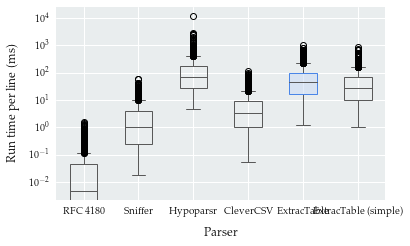

In [25]:
parser_map = {'cleverCSV': 'CleverCSV', 'hypoparsr': 'Hypoparsr', 'rfc4180': 'RFC 4180', 'sniffer': 'Sniffer', 'tableExtractor': 'ExtracTable', 'simple': 'ExtracTable (simple)'}
sort_parser_dict = {'RFC 4180': 0, 'Hypoparsr': 1, 'Sniffer': 2, 'CleverCSV': 3, 'ExtracTable': 4, 'ExtracTable (simple)': 5}
df = DataFrame([
    {
        'parser': parser_map[run_times_per_parser['metrics']['parser']],
        'runTimes': run_times_per_parser['metrics']['runTime'] * 1000
    }
    for run_times_per_parser in get_runtimes_per_line_per_parser_simple()
]).sort_values(
    by='parser', 
    key=lambda parser: parser.map(sort_parser_dict),
    ascending=True
)

ax = df.boxplot(
    by='parser',
    positions=[4,5,6,3,1,2],
    color=dict(boxes='#595959', whiskers='#595959', medians='#595959', caps='#595959'),
    
    patch_artist=True
)

[ax.findobj(mpl.patches.Patch)[p].set(alpha=None, facecolor='#59595900', edgecolor='#595959') for p in range(6) if p != 1]
ax.findobj(mpl.patches.Patch)[1].set(alpha=None, facecolor='#C9DAF780', edgecolor='#4A86E8')


ax.set(
    xlabel='Parser',
    ylabel='Run time per line (ms)',
    yscale='log',
    title=''
)

plt.suptitle('')

plt.tight_layout()
# ax.get_figure().savefig('run-time-line-level')

In [14]:
def get_runtimes_per_line_per_parser_include_pytheas():
    with MongoClient() as mongo:
        db = mongo['master']
        return db['metrics'].aggregate([
            {
                '$lookup': {
                    'from': 'pytheas', 
                    'localField': 'fileId', 
                    'foreignField': 'fileId', 
                    'as': 'pytheas'
                }
            }, {
                '$unwind': {
                    'path': '$pytheas'
                }
            }, {
                '$match': {
                    'pytheas.status': 'success'
                }
            }, {
                '$group': {
                    '_id': '$fileId', 
                    'successCount': {
                        '$sum': {
                            '$cond': [
                                {
                                    '$eq': [
                                        '$status', 'success'
                                    ]
                                }, 1, 0
                            ]
                        }
                    }, 
                    'metrics': {
                        '$push': {
                            'parser': '$parser', 
                            'runTime': {
                                '$divide': [
                                    '$runTime', '$lineMetrics_lineCount'
                                ]
                            }
                        }
                    }, 
                    'pytheas': {
                        '$push': {
                            'parser': 'pytheas', 
                            'runTime': {
                                '$divide': [
                                    '$pytheas.runTime', '$lineMetrics_lineCount'
                                ]
                            }
                        }
                    }
                }
            }, {
                '$match': {
                    'successCount': 5
                }
            }, {
                '$project': {
                    'metrics': {
                        '$concatArrays': [
                            '$metrics', [
                                {
                                    '$first': '$pytheas'
                                }
                            ]
                        ]
                    }
                }
            }, {
                '$unwind': {
                    'path': '$metrics'
                }
            }
        ])

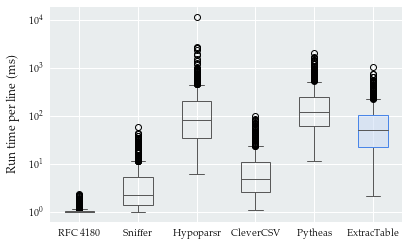

In [30]:
parser_map = {'cleverCSV': 'CleverCSV', 'hypoparsr': 'Hypoparsr', 'rfc4180': 'RFC 4180', 'sniffer': 'Sniffer', 'tableExtractor': 'ExtracTable', 'pytheas': 'Pytheas'}
sort_parser_dict = {'RFC 4180': 0, 'Hypoparsr': 1, 'Sniffer': 2, 'CleverCSV': 3, 'Pytheas': 4, 'ExtracTable': 5}
df = DataFrame([
    {
        'parser': parser_map[run_times_per_parser['metrics']['parser']],
        'runTimes': run_times_per_parser['metrics']['runTime'] * 1000 + 1  # + 1 to increase readability
    }
    for run_times_per_parser in get_runtimes_per_line_per_parser_include_pytheas()
]).sort_values(
    by='parser', 
    key=lambda parser: parser.map(sort_parser_dict),
    ascending=True
)

ax = df.boxplot(
    by='parser',
    positions=[4,6,3,5,1,2],
    color=dict(boxes='#595959', whiskers='#595959', medians='#595959', caps='#595959'),
    
    patch_artist=True
)

[ax.findobj(mpl.patches.Patch)[p].set(alpha=None, facecolor='#59595900', edgecolor='#595959') for p in range(6) if p != 1]
ax.findobj(mpl.patches.Patch)[1].set(alpha=None, facecolor='#C9DAF780', edgecolor='#4A86E8')


ax.set(
    xlabel='',
    ylabel='Run time per line (ms)',
    yscale='log',
    title=''
)

plt.suptitle('')

plt.tight_layout()
ax.get_figure().savefig('run-time-line-level')

# Experiment 5

Is the run time depending on the number of parsing instructions?

In [16]:
def get_run_times_per_parsing_instruction_per_parser():
    with MongoClient() as mongo:
        db = mongo['master']
        return db['metrics'].aggregate([
            {
                '$lookup': {
                    'from': 'files', 
                    'let': {
                        'fileId': {
                            '$toObjectId': '$fileId'
                        }
                    }, 
                    'pipeline': [
                        {
                            '$match': {
                                '$expr': {
                                    '$eq': [
                                        '$_id', '$$fileId'
                                    ]
                                }
                            }
                        }
                    ], 
                    'as': 'file'
                }
            }, {
                '$unwind': {
                    'path': '$file'
                }
            }, {
                '$match': {
                    'file.parsing_instructions': {
                        '$ne': None
                    }
                }
            }, {
                '$group': {
                    '_id': {
                        'fileId': '$fileId', 
                        'parsing_instructions': {
                            '$sum': [
                                '$file.parsing_instructions.character', '$file.parsing_instructions.layout'
                            ]
                        }
                    }, 
                    'successCount': {
                        '$sum': {
                            '$cond': [
                                {
                                    '$eq': [
                                        '$status', 'success'
                                    ]
                                }, 1, 0
                            ]
                        }
                    }, 
                    'metrics': {
                        '$push': {
                            'parser': '$parser', 
                            'runTime': '$runTime'
                        }
                    }
                }
            }, {
                '$match': {
                    'successCount': 5
                }
            }
        ])

Text(0.5, 0, 'run time in seconds')

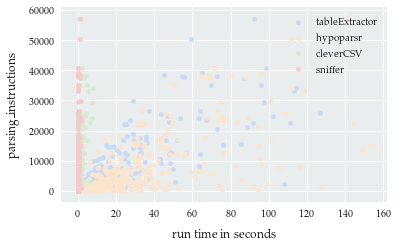

In [17]:
df = DataFrame([
    {
        'parsing\_instructions': run_times['_id']['parsing_instructions'],
        **{
            metric['parser']: metric['runTime']
            for metric in run_times['metrics']
        }
    }
    for run_times in get_run_times_per_parsing_instruction_per_parser()
])
ax1 = df.plot(kind='scatter', x='tableExtractor', label='tableExtractor', y='parsing\_instructions', color=mpl.rcParams['axes.prop_cycle'].by_key()['color'][0])
ax2 = df.plot(kind='scatter', x='hypoparsr', label='hypoparsr', y='parsing\_instructions', ax=ax1, color=mpl.rcParams['axes.prop_cycle'].by_key()['color'][1])
ax3 = df.plot(kind='scatter', x='cleverCSV', label='cleverCSV', y='parsing\_instructions', ax=ax2, color=mpl.rcParams['axes.prop_cycle'].by_key()['color'][2])
ax4 = df.plot(kind='scatter', x='sniffer', label='sniffer', y='parsing\_instructions', ax=ax3, color=mpl.rcParams['axes.prop_cycle'].by_key()['color'][3])
ax4.set_xlabel('run time in seconds')

# Experiment 6

Impact of different features.

In [18]:
def get_speedup(compare_to_collection):
    with MongoClient() as mongo:
        db = mongo['master']
        return db['metrics'].aggregate([
            {
                '$match': {
                    'parser': 'tableExtractor', 
                    'fileMetrics_incomplete': False, 
                    'status': 'success'
                }
            }, {
                '$lookup': {
                    'from': compare_to_collection, 
                    'let': {
                        'fileId': '$fileId', 
                        'parser': '$parser'
                    }, 
                    'pipeline': [
                        {
                            '$match': {
                                '$expr': {
                                    '$and': [
                                        {
                                            '$eq': [
                                                '$fileId', '$$fileId'
                                            ]
                                        }, {
                                            '$eq': [
                                                '$parser', '$$parser'
                                            ]
                                        }
                                    ]
                                }
                            }
                        }
                    ], 
                    'as': 'modified'
                }
            }, {
                '$unwind': {
                    'path': '$modified'
                }
            }, {
                '$project': {
                    'factor': {
                        '$divide': [
                            '$runTime', '$modified.runTime'
                        ]
                    }
                }
            }, {
                '$group': {
                    '_id': None, 
                    'avg': {
                        '$avg': '$factor'
                    }, 
                    'timedout': {
                        '$sum': {
                            '$cond': [
                                {
                                    '$eq': [
                                        '$factor', None
                                    ]
                                }, 1, 0
                            ]
                        }
                    }
                }
            }
        ])

In [19]:
next(get_speedup('metrics_ascii_disabled'))

{'_id': None, 'avg': 1.281064088290102, 'timedout': 0}

In [20]:
next(get_speedup('metrics_dt_disabled'))

{'_id': None, 'avg': 1.109383448113406, 'timedout': 1}

In [21]:
next(get_speedup('metrics_heuristic_180'))

{'_id': None, 'avg': 1.1052475728605742, 'timedout': 0}

In [22]:
next(get_speedup('metrics_simple_180'))

{'_id': None, 'avg': 1.6114896395502503, 'timedout': 0}

In [23]:
next(get_speedup('metrics_flexible_180'))

{'_id': None, 'avg': 0.8235096441411777, 'timedout': 131}

# Showcase 1

Is there a file that no parser finished?

Yes, there is one with id 5fa1dcfc6fea3636867e1df2. The file consists of 450 lines, each having 17365 characters.
CleverCSV, Pytheas and tableExtractor time out, sniffer and hypoparsr return exit code != 0

```
db.getCollection("metrics").aggregate([
    {
        '$match': {
            'parser': {'$nin': ['rfc4180']}
        }
    },{
        '$group': {
            '_id': '$fileId',
            'successCount': {
                '$sum': {
                    '$cond': [
                        {'$eq': ['$status', 'success']},
                        1,
                        0
                    ]
                }    
            }
        }
    },{
        '$match': {'successCount': 0}    
    },
])
```